In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import pdb

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [50]:
diamonds_df = pd.read_csv('diamonds.csv')

In [51]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


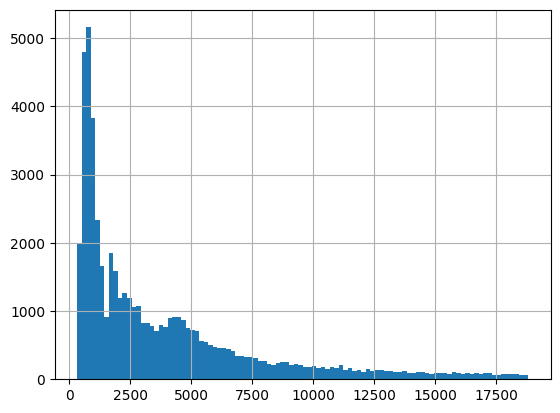

In [52]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [53]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [54]:
print([1,2])

[1, 2]


In [55]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [56]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [57]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,4,1,1,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,3,5,3,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,1,6,1,63.3,58.0,335,4.34,4.35,2.75


In [58]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [59]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

# Обучаем модель линейной регрессии

In [61]:
reg = LinearRegression().fit(X_train, y_train)

In [62]:
y_pred = reg.predict(X_test)

In [63]:
score = r2_score(y_pred, y_test)

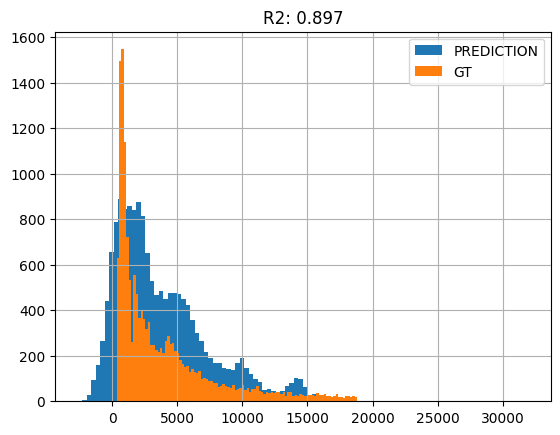

In [64]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Создаём модель MLP для задачи регрессии

In [282]:
class SigmoidLayer:
    def __init__(self) -> None:
        pass
    def forward(self,X):
        self.y = 1/(1 + np.exp(-X))
        return self.y
    def backward(self,dLdy):
        return dLdy * self.y * (1 - self.y)
    def step(self):
        pass

In [283]:
class ReluLayer:
    def __init__(self) -> None:
        pass
    def forward(self,X):
        return np.multiply((X>0),X)
    def backward(self,dLdy):
        return (dLdy>0) * 1
    def step(self):
        pass

In [422]:
class LinearLayer:
    def __init__(self, input_size,output_size,l_r):
        self.W = np.random.randn(input_size,output_size)
        self.b = np.random.randn(output_size) 
        self.l_r = l_r
        
    
    def forward(self, X):
        self.X = X
        #print(X.shape, self.W.shape)
        self.Y = X @ self.W + self.b
        return self.Y
    
    def backward(self, dLdy):
        dydw = self.W
        #X [N,input,1]
        #dLdy [N,1,output]
        #print('before = ',self.X.shape,dLdy.shape)
        self.dLdw = self.X.T @  dLdy # Because it is 3D matrix
        #print('after = ',np.expand_dims(self.X, -1).shape,np.expand_dims(dLdy, -2).shape)
        #print('dLdw = ',self.dLdw)
        #pdb.set_trace()

        
        self.dLdb = dLdy # as dy/db == 1
          
        if len(self.dLdw.shape) > 2:
                self.dLdw = self.dLdw.sum(axis=0)
        if len(self.dLdb) > 1:
             self.dLdb = self.dLdb.sum(axis=0)
        #pdb.set_trace()
        dLdx = dLdy @ self.W.T
        #print('dLdx=',dLdx)
        return dLdx
    def step(self):
        self.W -= self.dLdw * self.l_r
        self.b -= self.dLdb * self.l_r

In [423]:
def check_gradient(f,x,eps = 1e-6):
    y = np.ones(x.shape)
    for i in range(x.shape[0]):
            if (len(x.shape) > 1):
                for j in range(x.shape[1]):
                    x[i,j] += eps
                    f_plus = f(x)
                    x[i][j] -= 2 * eps
                    f_minus = f(x)
                    x[i][j] += eps

                    y[i][j] = (f_plus - f_minus) / (2 * eps)
            else:
                    x[i] += eps
                    f_plus = f(x)
                    x[i] -= 2 * eps
                    f_minus = f(x)
                    x[i] += eps

                    y[i] = (f_plus - f_minus) / (2 * eps)
    return y

test_x = np.array([[1.2, 3.4, 5.6],[7.8,8.9,9.1]])
linearTest = LinearLayer(3,2,0.1)
linearTest.forward(test_x)
def f(W,x=test_x):
      return linearTest.forward(x).sum()
    
check_gradient(f, linearTest.W)

array([[ 9.00000001,  9.        ],
       [12.29999999, 12.3       ],
       [14.7       , 14.7       ]])

In [424]:

linearTest.backward(np.ones(2))
print(linearTest.dLdw)

[ 9.  12.3 14.7]


In [425]:
class MSELOSS:
    def __init__(self) -> None:
        pass
    def forward(self,y,y_res):
        self.n = y.shape[0]
        #print(y.shape,y_res.shape)
        self.diff = y_res - y
        #print(self.diff.shape)
        self.L = (self.diff ** 2).mean()
        return self.L
    def backward(self):
        dLdy =   (-1 / self.n) * (2 * self.diff)
        return dLdy


In [426]:
class R2LOSS:
    def __init__(self) -> None:
        pass
    def forward(self,y,y_res):
        self.n = y.shape[0]
        self.diff = y - y_res 
        self.L = 1 - ( y - y_res) ** 2
        return self.L
    def backward(self):
        dLdy =   (1 / self.n) * (2 * self.diff)
        return dLdy

In [427]:
class MLPRegressor:
    def __init__(
        self,
        hidden_layer_sizes=(100,100),
        learning_rate=1e-6,
        max_iter=100,
        layers = None,
        loss = None
    ):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.hidden_layer_sizes = hidden_layer_sizes
        self.layers = layers
        self.loss = loss
        if (self.layers == None):
            self.layers = []
            layer_size = hidden_layer_sizes[1]
            for i in range(hidden_layer_sizes[0]): #layersCount
                self.layers.append(LinearLayer(layer_size,layer_size,learning_rate))
                self.layers.append(ReluLayer())
        self.layers.append(LinearLayer(layer_size,1,learning_rate))
        if (self.loss == None):
            self.loss = MSELOSS()
    
    def train(self, X, y):
        losses = []
        saved_X = X.copy()
        for i in range(self.max_iter):
            X = saved_X
            for layer in self.layers:
                X = layer.forward(X)
                #print(f'X =={X}',X)
            print(X.shape)
            L = self.loss.forward(X,y) # On last interation the input will be the result
            print('L=',L)
            losses.append(L)
            dLdy = self.loss.backward() 
            #dLdy = L
            #print('shape.loss==',dLdy.shape)
            for layer in self.layers[::-1]:
                dLdy = layer.backward(dLdy)

            for layer in self.layers:
                layer.step()
        return losses

    def predict(self, X):
        for layer in self.layers:
                X = layer.forward(X)
        return X

In [428]:
TestMSELOSS = MSELOSS()
chosen_size = 50
test_y = np.random.rand(chosen_size,1)
test_y_res = np.random.rand(chosen_size,1)
TestMSELOSS.forward(test_y,test_y_res)
def f_loss(W,y=test_y,y_res = test_y_res):
      return TestMSELOSS.forward(y,y_res).sum()
check_gradient(f_loss, test_y_res)

array([[ 0.002343  ],
       [-0.01354242],
       [-0.00096807],
       [-0.02349054],
       [ 0.0046358 ],
       [-0.00925049],
       [-0.00468343],
       [ 0.02369857],
       [ 0.00058459],
       [-0.0065705 ],
       [-0.01471999],
       [-0.00094785],
       [-0.00016838],
       [ 0.0131271 ],
       [-0.00028355],
       [-0.00247006],
       [-0.00068033],
       [-0.01645528],
       [-0.00901444],
       [ 0.01281941],
       [-0.01583109],
       [ 0.01233067],
       [ 0.02299264],
       [-0.03223455],
       [-0.01088115],
       [ 0.00478096],
       [-0.00929034],
       [-0.01161711],
       [ 0.00560049],
       [-0.0077819 ],
       [ 0.00975118],
       [ 0.03823502],
       [ 0.02935336],
       [-0.00824643],
       [ 0.02762957],
       [ 0.01978453],
       [ 0.0069451 ],
       [ 0.00227906],
       [ 0.01993671],
       [ 0.00057856],
       [ 0.00523619],
       [ 0.00026061],
       [ 0.01173899],
       [-0.00215594],
       [-0.01706843],
       [-0

In [429]:
test_y,test_y_res

(array([[0.38298861],
        [0.3606432 ],
        [0.66852968],
        [0.67143242],
        [0.05828177],
        [0.44313149],
        [0.91986242],
        [0.15438253],
        [0.73395582],
        [0.83023231],
        [0.83373779],
        [0.92350144],
        [0.81758745],
        [0.4353123 ],
        [0.77220697],
        [0.10137074],
        [0.10456944],
        [0.49042079],
        [0.33429921],
        [0.64093321],
        [0.45160098],
        [0.05988632],
        [0.09595586],
        [0.92355208],
        [0.89438243],
        [0.25229855],
        [0.94290149],
        [0.83141289],
        [0.25651717],
        [0.66640886],
        [0.14204052],
        [0.00804892],
        [0.18747843],
        [0.68346917],
        [0.20623538],
        [0.32689115],
        [0.78856635],
        [0.7995998 ],
        [0.49931482],
        [0.9613896 ],
        [0.14674701],
        [0.7910321 ],
        [0.10779642],
        [0.91071988],
        [0.85342257],
        [0

In [430]:
TestMSELOSS.backward()

array([[-0.002343  ],
       [ 0.01354242],
       [ 0.00096807],
       [ 0.02349054],
       [-0.0046358 ],
       [ 0.00925049],
       [ 0.00468343],
       [-0.02369857],
       [-0.00058459],
       [ 0.0065705 ],
       [ 0.01471999],
       [ 0.00094785],
       [ 0.00016838],
       [-0.0131271 ],
       [ 0.00028355],
       [ 0.00247006],
       [ 0.00068033],
       [ 0.01645528],
       [ 0.00901444],
       [-0.01281941],
       [ 0.01583109],
       [-0.01233067],
       [-0.02299264],
       [ 0.03223455],
       [ 0.01088115],
       [-0.00478096],
       [ 0.00929034],
       [ 0.01161711],
       [-0.00560049],
       [ 0.0077819 ],
       [-0.00975118],
       [-0.03823502],
       [-0.02935336],
       [ 0.00824643],
       [-0.02762957],
       [-0.01978453],
       [-0.0069451 ],
       [-0.00227906],
       [-0.01993671],
       [-0.00057856],
       [-0.00523619],
       [-0.00026061],
       [-0.01173899],
       [ 0.00215594],
       [ 0.01706843],
       [ 0

In [431]:
len(features)

9

# Проверяем модель MLP на выборке Diamonds

In [432]:
mlpRegressorTest = MLPRegressor(hidden_layer_sizes=(1,2))
a = np.array([[1.2,3.2],[3.4,5.6]])
b = np.array([1.3,2.3]).reshape(-1,1)

In [433]:
print(mlpRegressorTest.layers[0].W)
#mlpRegressorTest.layers[0].dLdw

[[ 0.77734936 -0.16680217]
 [-0.66380076  0.24566886]]


In [434]:
mlpRegressorTest.train(a,b)


(2, 1)
L= 5.127159916552872
(2, 1)
L= 5.1269137742299105
(2, 1)
L= 5.126667640661932
(2, 1)
L= 5.126421515848462
(2, 1)
L= 5.12617539978902
(2, 1)
L= 5.125929292483132
(2, 1)
L= 5.125683193930321
(2, 1)
L= 5.125437104130111
(2, 1)
L= 5.125191023082024
(2, 1)
L= 5.124944950785587
(2, 1)
L= 5.124698887240322
(2, 1)
L= 5.1244528324457495
(2, 1)
L= 5.124206786401397
(2, 1)
L= 5.123960749106788
(2, 1)
L= 5.123714720561443
(2, 1)
L= 5.12346870076489
(2, 1)
L= 5.12322268971665
(2, 1)
L= 5.122976687416248
(2, 1)
L= 5.1227306938632085
(2, 1)
L= 5.122484709057055
(2, 1)
L= 5.122238732997311
(2, 1)
L= 5.121992765683502
(2, 1)
L= 5.1217468071151515
(2, 1)
L= 5.121500857291784
(2, 1)
L= 5.121254916212924
(2, 1)
L= 5.1210089838780934
(2, 1)
L= 5.1207630602868175
(2, 1)
L= 5.1205171454386225
(2, 1)
L= 5.120271239333031
(2, 1)
L= 5.120025341969568
(2, 1)
L= 5.119779453347759
(2, 1)
L= 5.119533573467127
(2, 1)
L= 5.119287702327197
(2, 1)
L= 5.119041839927494
(2, 1)
L= 5.118795986267543
(2, 1)
L= 5.1185

[5.127159916552872,
 5.1269137742299105,
 5.126667640661932,
 5.126421515848462,
 5.12617539978902,
 5.125929292483132,
 5.125683193930321,
 5.125437104130111,
 5.125191023082024,
 5.124944950785587,
 5.124698887240322,
 5.1244528324457495,
 5.124206786401397,
 5.123960749106788,
 5.123714720561443,
 5.12346870076489,
 5.12322268971665,
 5.122976687416248,
 5.1227306938632085,
 5.122484709057055,
 5.122238732997311,
 5.121992765683502,
 5.1217468071151515,
 5.121500857291784,
 5.121254916212924,
 5.1210089838780934,
 5.1207630602868175,
 5.1205171454386225,
 5.120271239333031,
 5.120025341969568,
 5.119779453347759,
 5.119533573467127,
 5.119287702327197,
 5.119041839927494,
 5.118795986267543,
 5.118550141346867,
 5.118304305164991,
 5.118058477721442,
 5.117812659015743,
 5.117566849047419,
 5.117321047815995,
 5.117075255320996,
 5.116829471561948,
 5.116583696538374,
 5.116337930249801,
 5.116092172695754,
 5.115846423875755,
 5.115600683789332,
 5.115354952436011,
 5.1151092298153

In [444]:
mlpRegressor = MLPRegressor(hidden_layer_sizes=(30,len(features)),learning_rate=1e-3,max_iter=100)

In [445]:
print(X_train)

[[0.05197505 0.75       0.83333333 ... 0.45623836 0.08285229 0.09685535]
 [0.31185031 1.         0.33333333 ... 0.7122905  0.12852292 0.14937107]
 [0.07068607 1.         0.16666667 ... 0.49068901 0.08981324 0.10062893]
 ...
 [0.07276507 0.5        0.33333333 ... 0.49255121 0.09032258 0.10125786]
 [0.07068607 1.         0.33333333 ... 0.49068901 0.08913413 0.10125786]
 [0.03950104 0.75       0.5        ... 0.44134078 0.07962649 0.09025157]]


In [446]:
losses_mlp = mlpRegressor.train(X_train,y_train)

(37758, 1)
L= 3.0470482071006923e+49
(37758, 1)
L= 1.457094638472426e+43
(37758, 1)
L= 1.4512720882970903e+43
(37758, 1)
L= 1.4454728050322548e+43
(37758, 1)
L= 1.4396966957033456e+43
(37758, 1)
L= 1.433943667707315e+43
(37758, 1)
L= 1.4282136288111565e+43
(37758, 1)
L= 1.4225064871504275e+43
(37758, 1)
L= 1.416822151227774e+43
(37758, 1)
L= 1.4111605299114686e+43
(37758, 1)
L= 1.4055215324339414e+43
(37758, 1)
L= 1.3999050683903354e+43
(37758, 1)
L= 1.394311047737048e+43
(37758, 1)
L= 1.3887393807902911e+43
(37758, 1)
L= 1.3831899782246528e+43
(37758, 1)
L= 1.377662751071667e+43
(37758, 1)
L= 1.372157610718385e+43
(37758, 1)
L= 1.3666744689059538e+43
(37758, 1)
L= 1.3612132377282057e+43
(37758, 1)
L= 1.3557738296302437e+43
(37758, 1)
L= 1.350356157407041e+43
(37758, 1)
L= 1.3449601342020426e+43
(37758, 1)
L= 1.339585673505772e+43
(37758, 1)
L= 1.334232689154442e+43
(37758, 1)
L= 1.3289010953285814e+43
(37758, 1)
L= 1.3235908065516485e+43
(37758, 1)
L= 1.318301737688668e+43
(37758, 1)


KeyboardInterrupt: 

In [ ]:
y_pred_mlp = mlpRegressor.predict(X_test)


In [ ]:
score_mlp = r2_score(y_pred_mlp, y_test)

In [ ]:
print(y_pred_mlp)

[[3415.45671815]
 [3415.45671815]
 [3415.45671815]
 ...
 [3415.45671815]
 [3415.45671815]
 [3415.45671815]]


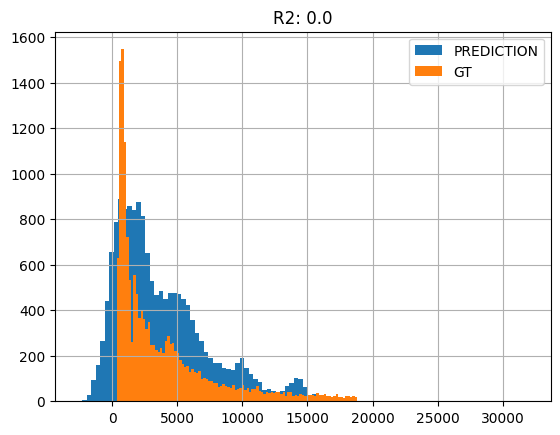

In [ ]:
plt.title(f'R2: {str(score_mlp)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid()

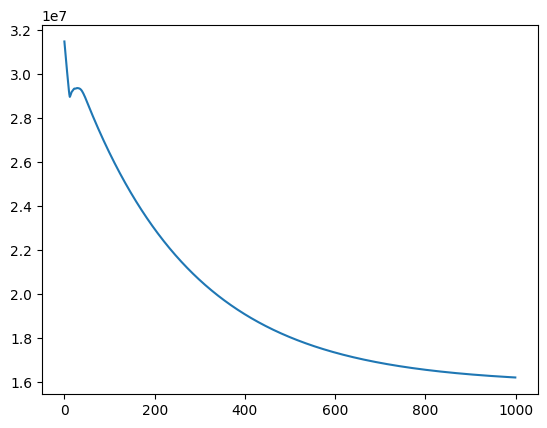

In [ ]:
plt.plot(losses_mlp)
plt.show()

In [ ]:
print(losses_mlp)
losses_mlp[-1]

[31498423.305514377, 31258841.611742955, 31022858.62002241, 30790357.17350907, 30561285.50747575, 30335592.62708254, 30113228.29592624, 29894143.024760112, 29678288.060381386, 29465615.374684095, 29261238.996930566, 29088042.98356787, 28977264.876959532, 29021604.74019376, 29083458.0202645, 29140127.26480702, 29197787.332951307, 29226120.858761538, 29259745.77042942, 29282488.58503225, 29308484.461833566, 29336169.828587513, 29354800.93964579, 29354288.2547233, 29354370.836093612, 29354785.880505946, 29363866.114627276, 29372806.317294527, 29376242.671902016, 29378855.719531264, 29376290.58945997, 29372565.804474365, 29367364.90921088, 29360229.133370664, 29350830.367704242, 29338666.580510296, 29320530.589195516, 29299438.187564764, 29272861.805108607, 29243353.378206495, 29209200.03643737, 29171105.59012282, 29132121.151022423, 29090290.206667703, 29046365.807574123, 29000728.862501826, 28954066.085348558, 28906334.290759876, 28856280.387621682, 28805299.7983847, 28754101.546921887, 

16210529.119701292